In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
from model.seg_model.model_scales_in import unet_scales
# from model.seg_model.model_scales_gate import unet_triple_gate
# from model.seg_model.model_scales_gate_tmp import unet_triple_gate
# from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*'))
paths_des = sorted(glob.glob(config.dir_des+'/*'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*'))
paths_patch = sorted(glob.glob(config.dir_patch_val+'/*'))
print(paths_as[0])


/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend/s1_as_scene_01.tif


In [4]:
'''--------- data loading --------'''
### ------ 1. training data loading: from scenes path ----- ### 
scene_list, truth_list = read_normalize(paths_as=paths_as, \
                            paths_des=paths_des, paths_truth=paths_truth)
tra_dset = threads_scene_dset(scene_list[0:15], \
                            truth_list[0:15], transforms=config.transforms_tra, num_thread=30)

### ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch]
val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())


size of training data: 450
size of val data: 250


In [5]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, \
                                batch_size=16)


In [6]:
## ------------ Model ------------ ##
## -------- 2. multiple scales -------
model = unet_scales(num_bands=4, num_classes=2, \
                    scale_high=2048, scale_mid=512, scale_low=256).to(device)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                        mode='min', factor=0.5, patience=10)


In [8]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)
            # x_batch = x_batch[2]        # !!!note: x_batch[2] for single-scale model
            y_batch = config.label_smooth(y_batch, 0.1)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                        optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)    # dynamic adjust learning rate

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)            
            # x_batch = x_batch[2]          #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                        x=x_batch, y=y_batch)

            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patches = [torch.unsqueeze(patch, 0).to(device) for patch in patches]
            truth = truth.to(device)
            pred = model(patches)
            patches = [patch[0].to('cpu').detach().numpy().transpose(1,2,0) for patch in patches]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patches_list = patches + [truth, pred]
            # ---- plot result
            plt.figure(figsize=(14,4))
            patches_name = ['input_high','input_mid','input_low','truth','pred']
            clip_list = [2,2,2,0,0]
            col_bands_list = [(2,1,0), (2,1,0), (2,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics

    

Ep1: tra-> Loss:0.495,Oa:0.838,Miou:0.742, val-> Loss:0.283,Oa:0.914,Miou:0.853,time:4.8s
Ep2: tra-> Loss:0.458,Oa:0.896,Miou:0.769, val-> Loss:0.272,Oa:0.898,Miou:0.776,time:4.5s
Ep3: tra-> Loss:0.431,Oa:0.911,Miou:0.828, val-> Loss:0.266,Oa:0.900,Miou:0.827,time:4.3s
Ep4: tra-> Loss:0.421,Oa:0.904,Miou:0.832, val-> Loss:0.295,Oa:0.889,Miou:0.745,time:4.5s
Ep5: tra-> Loss:0.411,Oa:0.926,Miou:0.854, val-> Loss:0.284,Oa:0.895,Miou:0.764,time:4.4s
Ep6: tra-> Loss:0.416,Oa:0.923,Miou:0.848, val-> Loss:0.188,Oa:0.953,Miou:0.911,time:4.4s
Ep7: tra-> Loss:0.410,Oa:0.926,Miou:0.847, val-> Loss:0.315,Oa:0.876,Miou:0.716,time:4.2s
Ep8: tra-> Loss:0.404,Oa:0.909,Miou:0.839, val-> Loss:0.213,Oa:0.938,Miou:0.882,time:4.3s
Ep9: tra-> Loss:0.388,Oa:0.939,Miou:0.873, val-> Loss:0.216,Oa:0.950,Miou:0.881,time:4.5s
Ep10: tra-> Loss:0.380,Oa:0.950,Miou:0.903, val-> Loss:0.356,Oa:0.883,Miou:0.673,time:4.3s


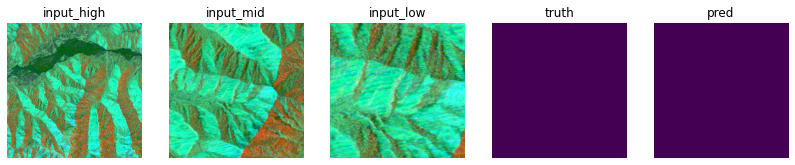

Ep11: tra-> Loss:0.407,Oa:0.928,Miou:0.850, val-> Loss:0.188,Oa:0.955,Miou:0.896,time:4.4s
Ep12: tra-> Loss:0.392,Oa:0.953,Miou:0.883, val-> Loss:0.194,Oa:0.935,Miou:0.890,time:4.4s
Ep13: tra-> Loss:0.395,Oa:0.942,Miou:0.889, val-> Loss:0.260,Oa:0.916,Miou:0.857,time:4.4s
Ep14: tra-> Loss:0.393,Oa:0.943,Miou:0.884, val-> Loss:0.328,Oa:0.890,Miou:0.733,time:4.4s
Ep15: tra-> Loss:0.383,Oa:0.953,Miou:0.900, val-> Loss:0.192,Oa:0.959,Miou:0.907,time:4.5s
Ep16: tra-> Loss:0.379,Oa:0.958,Miou:0.911, val-> Loss:0.221,Oa:0.929,Miou:0.881,time:4.4s
Ep17: tra-> Loss:0.380,Oa:0.948,Miou:0.895, val-> Loss:0.147,Oa:0.970,Miou:0.945,time:4.3s
Ep18: tra-> Loss:0.388,Oa:0.948,Miou:0.901, val-> Loss:0.238,Oa:0.928,Miou:0.848,time:4.4s
Ep19: tra-> Loss:0.370,Oa:0.966,Miou:0.928, val-> Loss:0.180,Oa:0.959,Miou:0.917,time:4.6s
Ep20: tra-> Loss:0.376,Oa:0.956,Miou:0.906, val-> Loss:0.153,Oa:0.967,Miou:0.936,time:4.3s


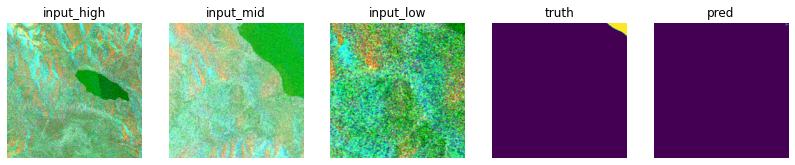

Ep21: tra-> Loss:0.384,Oa:0.939,Miou:0.886, val-> Loss:0.184,Oa:0.958,Miou:0.927,time:4.5s
Ep22: tra-> Loss:0.375,Oa:0.964,Miou:0.914, val-> Loss:0.226,Oa:0.929,Miou:0.879,time:4.4s
Ep23: tra-> Loss:0.377,Oa:0.938,Miou:0.889, val-> Loss:0.180,Oa:0.943,Miou:0.904,time:4.4s
Ep24: tra-> Loss:0.387,Oa:0.947,Miou:0.898, val-> Loss:0.363,Oa:0.897,Miou:0.710,time:4.3s
Ep25: tra-> Loss:0.384,Oa:0.951,Miou:0.892, val-> Loss:0.170,Oa:0.957,Miou:0.925,time:4.3s
Ep26: tra-> Loss:0.363,Oa:0.970,Miou:0.933, val-> Loss:0.186,Oa:0.947,Miou:0.910,time:4.3s
Ep27: tra-> Loss:0.356,Oa:0.958,Miou:0.931, val-> Loss:0.171,Oa:0.961,Miou:0.935,time:4.3s
Ep28: tra-> Loss:0.357,Oa:0.974,Miou:0.944, val-> Loss:0.180,Oa:0.955,Miou:0.923,time:4.4s
Ep29: tra-> Loss:0.378,Oa:0.941,Miou:0.898, val-> Loss:0.196,Oa:0.946,Miou:0.909,time:4.3s
Ep30: tra-> Loss:0.374,Oa:0.965,Miou:0.918, val-> Loss:0.206,Oa:0.958,Miou:0.900,time:4.3s


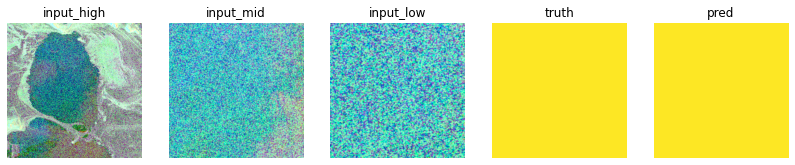

Ep31: tra-> Loss:0.377,Oa:0.963,Miou:0.920, val-> Loss:0.177,Oa:0.953,Miou:0.920,time:4.4s
Ep32: tra-> Loss:0.361,Oa:0.952,Miou:0.923, val-> Loss:0.160,Oa:0.969,Miou:0.945,time:4.5s
Ep33: tra-> Loss:0.371,Oa:0.961,Miou:0.924, val-> Loss:0.157,Oa:0.959,Miou:0.930,time:4.3s
Ep34: tra-> Loss:0.367,Oa:0.965,Miou:0.928, val-> Loss:0.297,Oa:0.894,Miou:0.764,time:4.4s
Ep35: tra-> Loss:0.369,Oa:0.960,Miou:0.920, val-> Loss:0.182,Oa:0.956,Miou:0.919,time:4.5s
Ep36: tra-> Loss:0.378,Oa:0.958,Miou:0.914, val-> Loss:0.243,Oa:0.941,Miou:0.862,time:4.2s
Ep37: tra-> Loss:0.383,Oa:0.940,Miou:0.890, val-> Loss:0.164,Oa:0.956,Miou:0.926,time:4.4s
Ep38: tra-> Loss:0.356,Oa:0.977,Miou:0.943, val-> Loss:0.216,Oa:0.940,Miou:0.879,time:4.3s
Ep39: tra-> Loss:0.351,Oa:0.979,Miou:0.953, val-> Loss:0.159,Oa:0.963,Miou:0.936,time:4.5s
Ep40: tra-> Loss:0.348,Oa:0.979,Miou:0.951, val-> Loss:0.192,Oa:0.942,Miou:0.902,time:4.4s


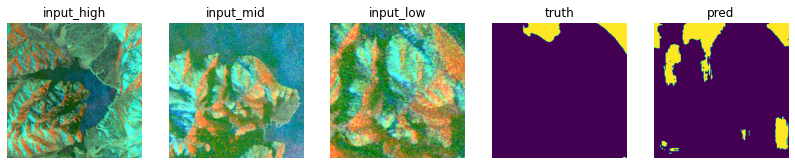

Ep41: tra-> Loss:0.357,Oa:0.957,Miou:0.928, val-> Loss:0.204,Oa:0.942,Miou:0.901,time:4.4s
Ep42: tra-> Loss:0.359,Oa:0.972,Miou:0.940, val-> Loss:0.218,Oa:0.924,Miou:0.871,time:4.4s
Ep43: tra-> Loss:0.351,Oa:0.958,Miou:0.938, val-> Loss:0.162,Oa:0.969,Miou:0.946,time:4.4s
Ep44: tra-> Loss:0.344,Oa:0.968,Miou:0.949, val-> Loss:0.170,Oa:0.958,Miou:0.928,time:4.4s
Ep45: tra-> Loss:0.349,Oa:0.978,Miou:0.958, val-> Loss:0.192,Oa:0.941,Miou:0.900,time:4.3s
Ep46: tra-> Loss:0.354,Oa:0.978,Miou:0.953, val-> Loss:0.167,Oa:0.964,Miou:0.938,time:4.5s
Ep47: tra-> Loss:0.355,Oa:0.972,Miou:0.947, val-> Loss:0.188,Oa:0.954,Miou:0.916,time:4.4s
Ep48: tra-> Loss:0.353,Oa:0.960,Miou:0.932, val-> Loss:0.173,Oa:0.963,Miou:0.930,time:4.3s
Ep49: tra-> Loss:0.346,Oa:0.983,Miou:0.962, val-> Loss:0.170,Oa:0.957,Miou:0.927,time:4.4s
Ep50: tra-> Loss:0.343,Oa:0.982,Miou:0.966, val-> Loss:0.168,Oa:0.965,Miou:0.935,time:4.2s


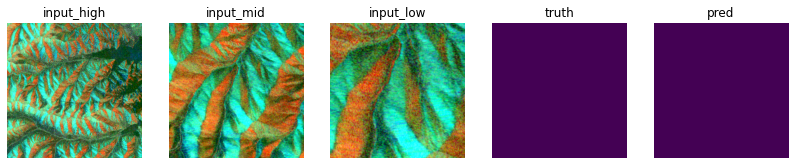

Ep51: tra-> Loss:0.354,Oa:0.975,Miou:0.952, val-> Loss:0.176,Oa:0.956,Miou:0.925,time:4.5s
Ep52: tra-> Loss:0.349,Oa:0.982,Miou:0.961, val-> Loss:0.169,Oa:0.961,Miou:0.934,time:4.3s
Ep53: tra-> Loss:0.348,Oa:0.982,Miou:0.949, val-> Loss:0.182,Oa:0.950,Miou:0.917,time:4.4s
Ep54: tra-> Loss:0.344,Oa:0.983,Miou:0.963, val-> Loss:0.163,Oa:0.962,Miou:0.935,time:4.4s
Ep55: tra-> Loss:0.350,Oa:0.982,Miou:0.956, val-> Loss:0.153,Oa:0.971,Miou:0.949,time:4.4s
Ep56: tra-> Loss:0.346,Oa:0.965,Miou:0.946, val-> Loss:0.211,Oa:0.934,Miou:0.887,time:4.4s
Ep57: tra-> Loss:0.348,Oa:0.981,Miou:0.960, val-> Loss:0.167,Oa:0.962,Miou:0.935,time:4.4s
Ep58: tra-> Loss:0.366,Oa:0.966,Miou:0.918, val-> Loss:0.199,Oa:0.947,Miou:0.910,time:4.4s
Ep59: tra-> Loss:0.358,Oa:0.956,Miou:0.929, val-> Loss:0.161,Oa:0.961,Miou:0.933,time:4.3s
Ep60: tra-> Loss:0.345,Oa:0.984,Miou:0.962, val-> Loss:0.190,Oa:0.947,Miou:0.902,time:4.4s


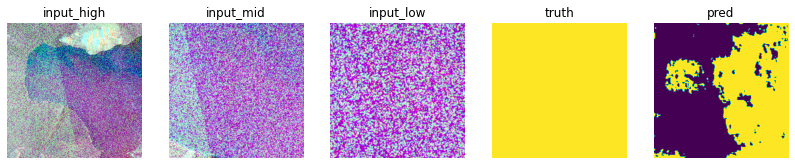

Ep61: tra-> Loss:0.346,Oa:0.980,Miou:0.962, val-> Loss:0.171,Oa:0.961,Miou:0.934,time:4.4s
Ep62: tra-> Loss:0.344,Oa:0.984,Miou:0.967, val-> Loss:0.173,Oa:0.959,Miou:0.931,time:4.3s
Ep63: tra-> Loss:0.347,Oa:0.980,Miou:0.960, val-> Loss:0.182,Oa:0.952,Miou:0.920,time:4.5s
Ep64: tra-> Loss:0.348,Oa:0.981,Miou:0.960, val-> Loss:0.168,Oa:0.961,Miou:0.934,time:4.4s
Ep65: tra-> Loss:0.341,Oa:0.987,Miou:0.972, val-> Loss:0.168,Oa:0.958,Miou:0.929,time:4.5s
Ep66: tra-> Loss:0.345,Oa:0.977,Miou:0.960, val-> Loss:0.165,Oa:0.962,Miou:0.936,time:4.3s
Ep67: tra-> Loss:0.349,Oa:0.979,Miou:0.957, val-> Loss:0.213,Oa:0.933,Miou:0.887,time:4.3s
Ep68: tra-> Loss:0.350,Oa:0.980,Miou:0.960, val-> Loss:0.173,Oa:0.957,Miou:0.926,time:4.4s
Ep69: tra-> Loss:0.344,Oa:0.984,Miou:0.966, val-> Loss:0.170,Oa:0.960,Miou:0.926,time:4.3s
Ep70: tra-> Loss:0.341,Oa:0.988,Miou:0.973, val-> Loss:0.182,Oa:0.951,Miou:0.908,time:4.3s


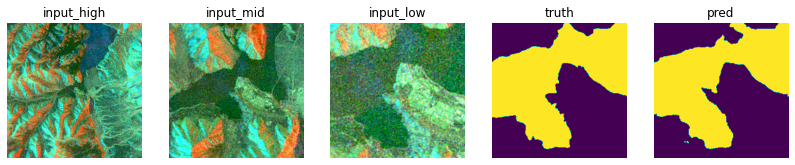

Ep71: tra-> Loss:0.343,Oa:0.986,Miou:0.969, val-> Loss:0.165,Oa:0.963,Miou:0.937,time:4.4s
Ep72: tra-> Loss:0.342,Oa:0.986,Miou:0.967, val-> Loss:0.168,Oa:0.961,Miou:0.935,time:4.4s
Ep73: tra-> Loss:0.342,Oa:0.987,Miou:0.970, val-> Loss:0.196,Oa:0.940,Miou:0.899,time:4.4s
Ep74: tra-> Loss:0.351,Oa:0.961,Miou:0.939, val-> Loss:0.168,Oa:0.961,Miou:0.934,time:4.5s
Ep75: tra-> Loss:0.347,Oa:0.979,Miou:0.957, val-> Loss:0.173,Oa:0.955,Miou:0.924,time:4.4s
Ep76: tra-> Loss:0.354,Oa:0.981,Miou:0.952, val-> Loss:0.189,Oa:0.949,Miou:0.914,time:4.4s
Ep77: tra-> Loss:0.377,Oa:0.957,Miou:0.904, val-> Loss:0.168,Oa:0.973,Miou:0.944,time:4.4s
Ep78: tra-> Loss:0.351,Oa:0.979,Miou:0.958, val-> Loss:0.153,Oa:0.966,Miou:0.941,time:4.5s
Ep79: tra-> Loss:0.350,Oa:0.982,Miou:0.958, val-> Loss:0.172,Oa:0.959,Miou:0.930,time:4.3s
Ep80: tra-> Loss:0.343,Oa:0.986,Miou:0.969, val-> Loss:0.169,Oa:0.960,Miou:0.933,time:4.4s


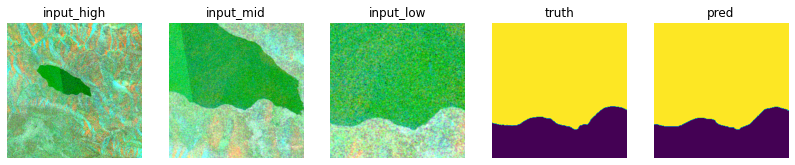

Ep81: tra-> Loss:0.342,Oa:0.985,Miou:0.969, val-> Loss:0.170,Oa:0.956,Miou:0.925,time:4.4s
Ep82: tra-> Loss:0.341,Oa:0.986,Miou:0.970, val-> Loss:0.161,Oa:0.966,Miou:0.941,time:4.7s
Ep83: tra-> Loss:0.346,Oa:0.982,Miou:0.958, val-> Loss:0.185,Oa:0.949,Miou:0.914,time:4.5s
Ep84: tra-> Loss:0.346,Oa:0.964,Miou:0.945, val-> Loss:0.167,Oa:0.961,Miou:0.935,time:4.5s
Ep85: tra-> Loss:0.345,Oa:0.985,Miou:0.968, val-> Loss:0.166,Oa:0.961,Miou:0.934,time:4.3s
Ep86: tra-> Loss:0.339,Oa:0.989,Miou:0.976, val-> Loss:0.165,Oa:0.961,Miou:0.934,time:4.3s
Ep87: tra-> Loss:0.343,Oa:0.984,Miou:0.967, val-> Loss:0.173,Oa:0.956,Miou:0.926,time:4.6s
Ep88: tra-> Loss:0.344,Oa:0.983,Miou:0.955, val-> Loss:0.166,Oa:0.961,Miou:0.934,time:4.4s
Ep89: tra-> Loss:0.339,Oa:0.988,Miou:0.976, val-> Loss:0.172,Oa:0.956,Miou:0.926,time:4.3s
Ep90: tra-> Loss:0.339,Oa:0.988,Miou:0.973, val-> Loss:0.168,Oa:0.959,Miou:0.931,time:4.5s


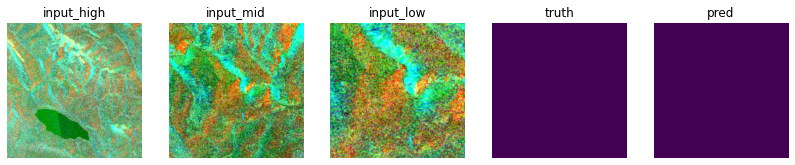

Ep91: tra-> Loss:0.345,Oa:0.979,Miou:0.957, val-> Loss:0.164,Oa:0.965,Miou:0.940,time:4.5s
Ep92: tra-> Loss:0.346,Oa:0.970,Miou:0.951, val-> Loss:0.194,Oa:0.943,Miou:0.903,time:4.6s
Ep93: tra-> Loss:0.339,Oa:0.989,Miou:0.975, val-> Loss:0.159,Oa:0.965,Miou:0.940,time:4.4s
Ep94: tra-> Loss:0.341,Oa:0.988,Miou:0.972, val-> Loss:0.163,Oa:0.963,Miou:0.937,time:4.5s
Ep95: tra-> Loss:0.339,Oa:0.987,Miou:0.974, val-> Loss:0.169,Oa:0.959,Miou:0.931,time:4.5s
Ep96: tra-> Loss:0.338,Oa:0.987,Miou:0.972, val-> Loss:0.159,Oa:0.965,Miou:0.940,time:4.3s
Ep97: tra-> Loss:0.339,Oa:0.988,Miou:0.976, val-> Loss:0.159,Oa:0.966,Miou:0.942,time:4.5s
Ep98: tra-> Loss:0.339,Oa:0.989,Miou:0.976, val-> Loss:0.167,Oa:0.960,Miou:0.932,time:4.3s
Ep99: tra-> Loss:0.340,Oa:0.986,Miou:0.972, val-> Loss:0.161,Oa:0.964,Miou:0.939,time:4.4s
Ep100: tra-> Loss:0.343,Oa:0.969,Miou:0.950, val-> Loss:0.178,Oa:0.951,Miou:0.918,time:4.3s


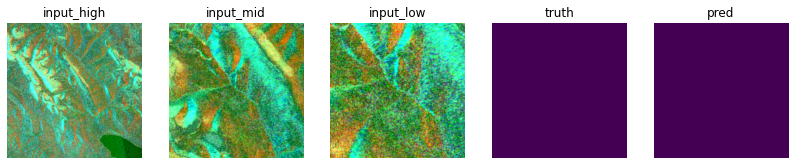

Ep101: tra-> Loss:0.338,Oa:0.973,Miou:0.960, val-> Loss:0.181,Oa:0.949,Miou:0.915,time:4.4s
Ep102: tra-> Loss:0.338,Oa:0.971,Miou:0.958, val-> Loss:0.172,Oa:0.955,Miou:0.924,time:4.4s
Ep103: tra-> Loss:0.340,Oa:0.987,Miou:0.970, val-> Loss:0.172,Oa:0.956,Miou:0.926,time:4.3s
Ep104: tra-> Loss:0.338,Oa:0.972,Miou:0.958, val-> Loss:0.169,Oa:0.958,Miou:0.929,time:4.5s
Ep105: tra-> Loss:0.340,Oa:0.971,Miou:0.958, val-> Loss:0.180,Oa:0.951,Miou:0.917,time:4.3s
Ep106: tra-> Loss:0.339,Oa:0.988,Miou:0.974, val-> Loss:0.185,Oa:0.948,Miou:0.912,time:4.3s
Ep107: tra-> Loss:0.338,Oa:0.990,Miou:0.977, val-> Loss:0.191,Oa:0.944,Miou:0.906,time:4.4s
Ep108: tra-> Loss:0.342,Oa:0.986,Miou:0.971, val-> Loss:0.189,Oa:0.946,Miou:0.909,time:4.5s
Ep109: tra-> Loss:0.344,Oa:0.965,Miou:0.946, val-> Loss:0.188,Oa:0.945,Miou:0.907,time:4.4s
Ep110: tra-> Loss:0.342,Oa:0.985,Miou:0.965, val-> Loss:0.168,Oa:0.957,Miou:0.928,time:4.5s


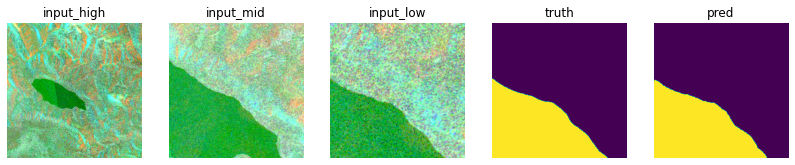

Ep111: tra-> Loss:0.339,Oa:0.989,Miou:0.976, val-> Loss:0.164,Oa:0.960,Miou:0.932,time:4.6s
Ep112: tra-> Loss:0.340,Oa:0.986,Miou:0.970, val-> Loss:0.181,Oa:0.949,Miou:0.915,time:4.5s
Ep113: tra-> Loss:0.343,Oa:0.975,Miou:0.958, val-> Loss:0.174,Oa:0.954,Miou:0.922,time:4.2s
Ep114: tra-> Loss:0.339,Oa:0.989,Miou:0.975, val-> Loss:0.162,Oa:0.965,Miou:0.937,time:4.4s
Ep115: tra-> Loss:0.339,Oa:0.988,Miou:0.975, val-> Loss:0.166,Oa:0.961,Miou:0.934,time:4.5s
Ep116: tra-> Loss:0.345,Oa:0.981,Miou:0.954, val-> Loss:0.180,Oa:0.951,Miou:0.917,time:4.4s
Ep117: tra-> Loss:0.343,Oa:0.967,Miou:0.950, val-> Loss:0.180,Oa:0.951,Miou:0.917,time:4.4s
Ep118: tra-> Loss:0.338,Oa:0.990,Miou:0.978, val-> Loss:0.175,Oa:0.953,Miou:0.921,time:4.3s
Ep119: tra-> Loss:0.340,Oa:0.988,Miou:0.973, val-> Loss:0.201,Oa:0.938,Miou:0.895,time:4.4s
Ep120: tra-> Loss:0.339,Oa:0.989,Miou:0.976, val-> Loss:0.197,Oa:0.940,Miou:0.899,time:4.4s


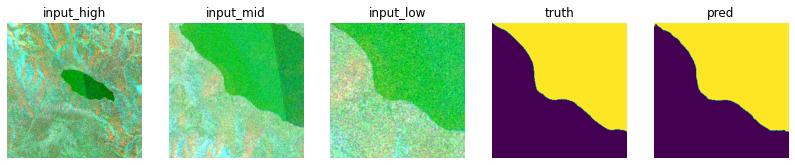

Ep121: tra-> Loss:0.339,Oa:0.987,Miou:0.973, val-> Loss:0.180,Oa:0.950,Miou:0.914,time:4.3s
Ep122: tra-> Loss:0.336,Oa:0.991,Miou:0.979, val-> Loss:0.176,Oa:0.952,Miou:0.918,time:4.3s
Ep123: tra-> Loss:0.341,Oa:0.987,Miou:0.973, val-> Loss:0.183,Oa:0.949,Miou:0.912,time:4.4s
Ep124: tra-> Loss:0.338,Oa:0.989,Miou:0.977, val-> Loss:0.186,Oa:0.946,Miou:0.909,time:4.4s
Ep125: tra-> Loss:0.337,Oa:0.971,Miou:0.958, val-> Loss:0.168,Oa:0.958,Miou:0.928,time:4.4s
Ep126: tra-> Loss:0.338,Oa:0.972,Miou:0.958, val-> Loss:0.175,Oa:0.954,Miou:0.923,time:4.4s
Ep127: tra-> Loss:0.337,Oa:0.989,Miou:0.976, val-> Loss:0.168,Oa:0.958,Miou:0.929,time:4.4s
Ep128: tra-> Loss:0.336,Oa:0.989,Miou:0.979, val-> Loss:0.160,Oa:0.964,Miou:0.938,time:4.3s
Ep129: tra-> Loss:0.340,Oa:0.988,Miou:0.971, val-> Loss:0.170,Oa:0.958,Miou:0.928,time:4.5s
Ep130: tra-> Loss:0.340,Oa:0.986,Miou:0.966, val-> Loss:0.164,Oa:0.960,Miou:0.932,time:4.3s


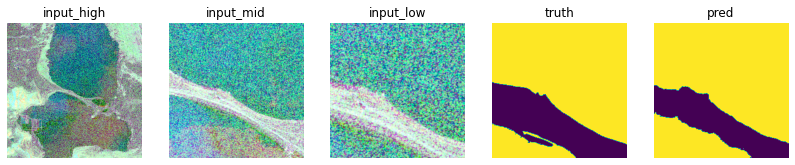

Ep131: tra-> Loss:0.341,Oa:0.986,Miou:0.962, val-> Loss:0.170,Oa:0.957,Miou:0.928,time:4.4s
Ep132: tra-> Loss:0.340,Oa:0.988,Miou:0.974, val-> Loss:0.183,Oa:0.950,Miou:0.916,time:4.3s
Ep133: tra-> Loss:0.340,Oa:0.969,Miou:0.955, val-> Loss:0.172,Oa:0.956,Miou:0.926,time:4.4s
Ep134: tra-> Loss:0.344,Oa:0.982,Miou:0.964, val-> Loss:0.186,Oa:0.947,Miou:0.911,time:4.3s
Ep135: tra-> Loss:0.337,Oa:0.990,Miou:0.980, val-> Loss:0.166,Oa:0.959,Miou:0.930,time:4.3s
Ep136: tra-> Loss:0.336,Oa:0.974,Miou:0.964, val-> Loss:0.173,Oa:0.954,Miou:0.923,time:4.3s
Ep137: tra-> Loss:0.340,Oa:0.987,Miou:0.973, val-> Loss:0.165,Oa:0.961,Miou:0.934,time:4.3s
Ep138: tra-> Loss:0.339,Oa:0.989,Miou:0.976, val-> Loss:0.163,Oa:0.963,Miou:0.936,time:4.3s
Ep139: tra-> Loss:0.336,Oa:0.973,Miou:0.961, val-> Loss:0.159,Oa:0.964,Miou:0.939,time:4.4s
Ep140: tra-> Loss:0.340,Oa:0.988,Miou:0.973, val-> Loss:0.159,Oa:0.965,Miou:0.940,time:4.3s


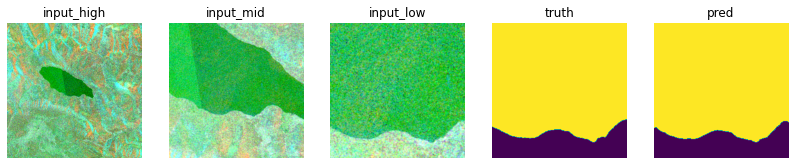

Ep141: tra-> Loss:0.338,Oa:0.972,Miou:0.960, val-> Loss:0.166,Oa:0.960,Miou:0.932,time:4.4s
Ep142: tra-> Loss:0.341,Oa:0.985,Miou:0.962, val-> Loss:0.171,Oa:0.957,Miou:0.926,time:4.4s
Ep143: tra-> Loss:0.341,Oa:0.987,Miou:0.974, val-> Loss:0.174,Oa:0.954,Miou:0.922,time:4.4s
Ep144: tra-> Loss:0.340,Oa:0.987,Miou:0.973, val-> Loss:0.187,Oa:0.946,Miou:0.910,time:4.4s
Ep145: tra-> Loss:0.337,Oa:0.990,Miou:0.978, val-> Loss:0.174,Oa:0.954,Miou:0.922,time:4.4s
Ep146: tra-> Loss:0.337,Oa:0.989,Miou:0.977, val-> Loss:0.168,Oa:0.958,Miou:0.928,time:4.4s
Ep147: tra-> Loss:0.344,Oa:0.983,Miou:0.963, val-> Loss:0.188,Oa:0.947,Miou:0.911,time:4.3s
Ep148: tra-> Loss:0.337,Oa:0.990,Miou:0.978, val-> Loss:0.172,Oa:0.956,Miou:0.925,time:4.4s
Ep149: tra-> Loss:0.336,Oa:0.992,Miou:0.982, val-> Loss:0.170,Oa:0.957,Miou:0.928,time:4.4s
Ep150: tra-> Loss:0.342,Oa:0.986,Miou:0.970, val-> Loss:0.183,Oa:0.950,Miou:0.915,time:4.4s


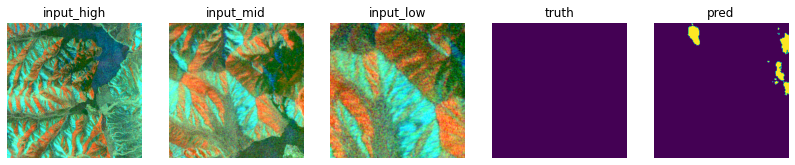

Ep151: tra-> Loss:0.339,Oa:0.971,Miou:0.958, val-> Loss:0.177,Oa:0.953,Miou:0.920,time:4.5s
Ep152: tra-> Loss:0.338,Oa:0.989,Miou:0.963, val-> Loss:0.179,Oa:0.952,Miou:0.919,time:4.4s
Ep153: tra-> Loss:0.336,Oa:0.973,Miou:0.961, val-> Loss:0.190,Oa:0.945,Miou:0.907,time:4.4s
Ep154: tra-> Loss:0.335,Oa:0.991,Miou:0.981, val-> Loss:0.174,Oa:0.955,Miou:0.923,time:4.3s
Ep155: tra-> Loss:0.340,Oa:0.987,Miou:0.973, val-> Loss:0.179,Oa:0.952,Miou:0.918,time:4.4s
Ep156: tra-> Loss:0.336,Oa:0.991,Miou:0.979, val-> Loss:0.181,Oa:0.950,Miou:0.916,time:4.3s
Ep157: tra-> Loss:0.339,Oa:0.988,Miou:0.974, val-> Loss:0.188,Oa:0.946,Miou:0.909,time:4.3s
Ep158: tra-> Loss:0.337,Oa:0.989,Miou:0.977, val-> Loss:0.181,Oa:0.950,Miou:0.916,time:4.4s
Ep159: tra-> Loss:0.341,Oa:0.986,Miou:0.971, val-> Loss:0.171,Oa:0.958,Miou:0.927,time:4.5s
Ep160: tra-> Loss:0.338,Oa:0.987,Miou:0.971, val-> Loss:0.165,Oa:0.961,Miou:0.933,time:4.5s


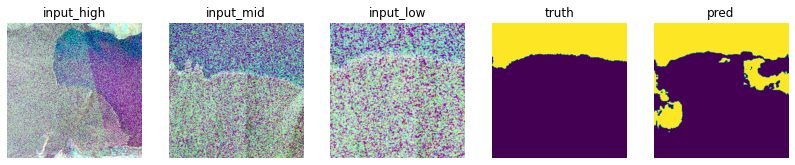

Ep161: tra-> Loss:0.336,Oa:0.974,Miou:0.962, val-> Loss:0.166,Oa:0.960,Miou:0.931,time:4.7s
Ep162: tra-> Loss:0.335,Oa:0.992,Miou:0.981, val-> Loss:0.166,Oa:0.959,Miou:0.931,time:4.4s
Ep163: tra-> Loss:0.338,Oa:0.985,Miou:0.969, val-> Loss:0.174,Oa:0.955,Miou:0.923,time:4.4s
Ep164: tra-> Loss:0.338,Oa:0.988,Miou:0.974, val-> Loss:0.172,Oa:0.956,Miou:0.925,time:4.4s
Ep165: tra-> Loss:0.337,Oa:0.990,Miou:0.978, val-> Loss:0.173,Oa:0.955,Miou:0.924,time:4.3s
Ep166: tra-> Loss:0.344,Oa:0.968,Miou:0.952, val-> Loss:0.181,Oa:0.950,Miou:0.916,time:4.4s
Ep167: tra-> Loss:0.339,Oa:0.973,Miou:0.960, val-> Loss:0.173,Oa:0.955,Miou:0.923,time:4.3s
Ep168: tra-> Loss:0.339,Oa:0.989,Miou:0.975, val-> Loss:0.180,Oa:0.951,Miou:0.917,time:4.5s
Ep169: tra-> Loss:0.340,Oa:0.983,Miou:0.969, val-> Loss:0.180,Oa:0.950,Miou:0.916,time:4.5s
Ep170: tra-> Loss:0.339,Oa:0.987,Miou:0.971, val-> Loss:0.166,Oa:0.960,Miou:0.931,time:4.4s


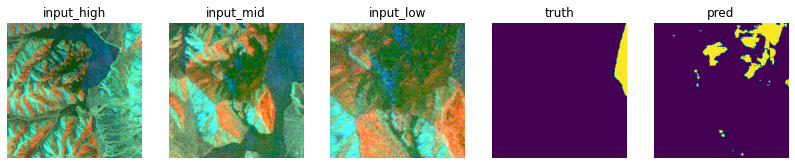

Ep171: tra-> Loss:0.339,Oa:0.988,Miou:0.976, val-> Loss:0.167,Oa:0.959,Miou:0.930,time:4.3s
Ep172: tra-> Loss:0.338,Oa:0.991,Miou:0.978, val-> Loss:0.185,Oa:0.948,Miou:0.912,time:4.5s
Ep173: tra-> Loss:0.342,Oa:0.987,Miou:0.971, val-> Loss:0.188,Oa:0.946,Miou:0.908,time:4.5s
Ep174: tra-> Loss:0.338,Oa:0.988,Miou:0.975, val-> Loss:0.184,Oa:0.948,Miou:0.913,time:4.3s
Ep175: tra-> Loss:0.337,Oa:0.988,Miou:0.975, val-> Loss:0.178,Oa:0.952,Miou:0.918,time:4.4s
Ep176: tra-> Loss:0.337,Oa:0.990,Miou:0.980, val-> Loss:0.178,Oa:0.952,Miou:0.918,time:4.4s
Ep177: tra-> Loss:0.340,Oa:0.988,Miou:0.960, val-> Loss:0.177,Oa:0.952,Miou:0.919,time:4.3s
Ep178: tra-> Loss:0.340,Oa:0.987,Miou:0.972, val-> Loss:0.182,Oa:0.950,Miou:0.915,time:4.3s
Ep179: tra-> Loss:0.339,Oa:0.987,Miou:0.974, val-> Loss:0.178,Oa:0.952,Miou:0.919,time:4.2s
Ep180: tra-> Loss:0.341,Oa:0.988,Miou:0.967, val-> Loss:0.176,Oa:0.954,Miou:0.922,time:4.4s


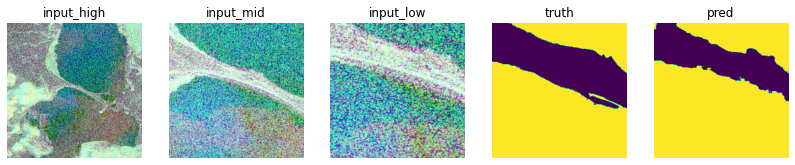

Ep181: tra-> Loss:0.343,Oa:0.986,Miou:0.970, val-> Loss:0.177,Oa:0.954,Miou:0.922,time:4.4s
Ep182: tra-> Loss:0.338,Oa:0.989,Miou:0.975, val-> Loss:0.181,Oa:0.952,Miou:0.918,time:4.4s
Ep183: tra-> Loss:0.338,Oa:0.989,Miou:0.963, val-> Loss:0.182,Oa:0.951,Miou:0.916,time:4.5s
Ep184: tra-> Loss:0.336,Oa:0.991,Miou:0.980, val-> Loss:0.181,Oa:0.951,Miou:0.917,time:4.2s
Ep185: tra-> Loss:0.336,Oa:0.974,Miou:0.963, val-> Loss:0.179,Oa:0.952,Miou:0.919,time:4.4s
Ep186: tra-> Loss:0.336,Oa:0.990,Miou:0.979, val-> Loss:0.176,Oa:0.954,Miou:0.922,time:4.3s
Ep187: tra-> Loss:0.343,Oa:0.984,Miou:0.969, val-> Loss:0.174,Oa:0.956,Miou:0.925,time:4.2s
Ep188: tra-> Loss:0.340,Oa:0.986,Miou:0.969, val-> Loss:0.179,Oa:0.952,Miou:0.920,time:4.3s
Ep189: tra-> Loss:0.339,Oa:0.988,Miou:0.973, val-> Loss:0.178,Oa:0.953,Miou:0.921,time:4.3s
Ep190: tra-> Loss:0.344,Oa:0.984,Miou:0.967, val-> Loss:0.175,Oa:0.955,Miou:0.923,time:4.3s


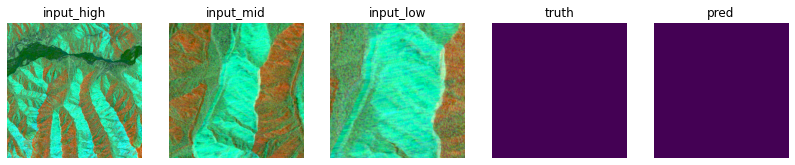

Ep191: tra-> Loss:0.338,Oa:0.989,Miou:0.974, val-> Loss:0.186,Oa:0.948,Miou:0.912,time:4.4s
Ep192: tra-> Loss:0.341,Oa:0.986,Miou:0.970, val-> Loss:0.186,Oa:0.948,Miou:0.912,time:4.4s
Ep193: tra-> Loss:0.337,Oa:0.990,Miou:0.978, val-> Loss:0.183,Oa:0.950,Miou:0.915,time:4.5s
Ep194: tra-> Loss:0.341,Oa:0.987,Miou:0.970, val-> Loss:0.181,Oa:0.951,Miou:0.917,time:4.3s
Ep195: tra-> Loss:0.340,Oa:0.987,Miou:0.973, val-> Loss:0.179,Oa:0.951,Miou:0.918,time:4.4s
Ep196: tra-> Loss:0.338,Oa:0.972,Miou:0.960, val-> Loss:0.178,Oa:0.952,Miou:0.919,time:4.5s
Ep197: tra-> Loss:0.339,Oa:0.986,Miou:0.965, val-> Loss:0.181,Oa:0.951,Miou:0.917,time:4.4s
Ep198: tra-> Loss:0.337,Oa:0.991,Miou:0.980, val-> Loss:0.180,Oa:0.951,Miou:0.917,time:4.7s
Ep199: tra-> Loss:0.338,Oa:0.989,Miou:0.976, val-> Loss:0.179,Oa:0.951,Miou:0.918,time:4.4s
Ep200: tra-> Loss:0.338,Oa:0.988,Miou:0.976, val-> Loss:0.178,Oa:0.952,Miou:0.919,time:4.3s


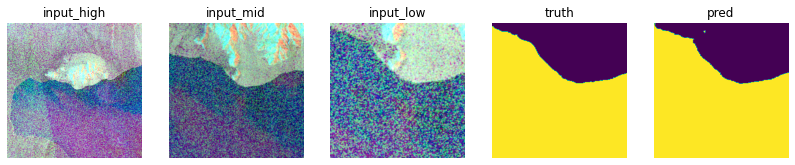

In [9]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce,  
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,   
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [10]:
# model_name = 'model_scales_in_test_001'
# # model save/load
# model_weights = config.root_proj + '/model/pretrained/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), model_weights)
# # model.load_state_dict(torch.load(model_weights))



In [11]:
# ## metrics saving
# metrics_path = config.root_proj + '/model/pretrained/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(metrics_path, index=False, sep=',')
# # metrics_df = pd.read_csv(metrics_path)
